In [2]:
import os
import pandas as pd
import collections
import compress_pickle
import copy
import fnmatch
import itertools
import libsbml
import numpy as np
import time
import matplotlib.pyplot as plt

# Import my local AMAS package
import sys
sys.path.insert(0, '/Users/luna/Desktop/CRBM/AMAS_proj/AMAS-v2')
from AMAS import recommender
from AMAS import constants as cn 

In [3]:
# Directory
biomd_model_dir = '/Users/luna/Desktop/CRBM/AMAS_proj/Models/BioModels'
bigg_model_dir = '/Users/luna/Desktop/CRBM/AMAS_proj/Models/BiggModels'
output_dir = '/Users/luna/Desktop/CRBM/AMAS_proj/Results/'

In [3]:
# Test for errors for all model files
model_files = [f for f in os.listdir(biomd_model_dir) if f.endswith('.xml')]

for idx, model_file in enumerate(model_files):
    if idx % 100 == 0:
        print("We are at", idx)
    print("processing", model_file)
    one_fpath = os.path.join(biomd_model_dir, model_file)
    try:
        recom = recommender.Recommender(libsbml_fpath=one_fpath)
    except Exception as e:
        with open('error_log.txt', 'a') as log_file:
            log_file.write(f"Error processing {model_file}: {str(e)}\n")
        continue

We are at 0
processing BIOMD0000000634.xml
processing BIOMD0000000152.xml
processing BIOMD0000000146.xml
processing BIOMD0000000620.xml
processing BIOMD0000000608.xml
processing BIOMD0000000191.xml
processing BIOMD0000000185.xml
processing BIOMD0000000813.xml
processing BIOMD0000000807.xml
processing BIOMD0000000350.xml
processing BIOMD0000000436.xml
processing BIOMD0000000422.xml
processing BIOMD0000000344.xml
processing BIOMD0000001072.xml
processing BIOMD0000000378.xml
processing BIOMD0000000393.xml
processing BIOMD0000000387.xml
processing BIOMD0000000224.xml
processing BIOMD0000000542.xml
processing BIOMD0000000556.xml
processing BIOMD0000000230.xml
processing BIOMD0000000218.xml
processing BIOMD0000000581.xml
processing BIOMD0000000595.xml
processing BIOMD0000000740.xml
processing BIOMD0000000998.xml
processing BIOMD0000000026.xml
processing BIOMD0000000032.xml
processing BIOMD0000000754.xml
processing BIOMD0000000768.xml
processing BIOMD0000000783.xml
processing BIOMD0000000797.

## Functions

In [4]:
def generate_model_species_statistics(model_dir, output_csv):
    model_statistics_data = []

    # All SBML files in the model directory
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.xml')]

    for idx, model_file in enumerate(model_files):
        if idx % 100 == 0:
            print("We are at", idx)
        one_fpath = os.path.join(model_dir, model_file)
        reader = libsbml.SBMLReader()
        document = reader.readSBML(one_fpath)
        model = document.getModel()
        recom = recommender.Recommender(libsbml_fpath=one_fpath)

        # Get species statistics
        num_species = model.getNumSpecies()
        specs2evaluate = list(recom.species.exist_annotation_formula.keys())
        num_annotated_species = len(specs2evaluate)
        annotated = num_annotated_species > 0
        
        # Append the results for this species
        model_statistics_data.append({
            'model': model_file,
            'annotated': annotated,
            'num_species': num_species,
            'num_annotated_species': num_annotated_species
        })


    # Create a DataFrame from the collected data
    df = pd.DataFrame(model_statistics_data)

    # Save the DataFrame to a CSV file
    df.to_csv(output_csv, index=False)


def generate_species_accuracy(model_dir, output_csv):
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.xml')]
    
    model_names = []
    species_id = []
    species_name = []
    len_names = []
    predictions = []
    num_cands = []
    num_formulas = []
    match_scores = []
    recall_formula = []
    precision_formula = []
    recall_chebi = []
    precision_chebi = []
    is_correct_included = []
    processing_time = []

    for idx,model_file in enumerate(model_files):
        print("We are at", idx)
        one_fpath = os.path.join(model_dir, model_file)
        recom = recommender.Recommender(libsbml_fpath=one_fpath)
        specs2evaluate = list(recom.species.exist_annotation_formula.keys())
        # run algorithm if there is at least one species to evaluate
        if specs2evaluate:
            time_start = time.time()
            recoms = recom.getSpeciesListRecommendation(pred_ids=specs2evaluate)
            time_end = time.time()
            recalls_formula = recom.getSpeciesStatistics(model_mean=False)['recall_formula']
            precisions_formula = recom.getSpeciesStatistics(model_mean=False)['precision_formula']
            recalls_chebi = recom.getSpeciesStatistics(model_mean=False)['recall_chebi']
            precisions_chebi = recom.getSpeciesStatistics(model_mean=False)['precision_chebi']
            for one_recom in recoms:
                model_names.append(model_file)
                one_spec = one_recom.id
                species_id.append(one_spec)
                species_name.append(recom.species.getNameToUse(one_spec))
                len_names.append(len(species_name[-1]))
                predictions.append(one_recom.candidates)
                num_cands.append(len(one_recom.candidates))
                num_formulas.append(len(recom.species.formula[one_spec]))
                match_scores.append(one_recom.candidates[0][1])
                recall_formula.append(recalls_formula[one_spec])
                precision_formula.append(precisions_formula[one_spec])
                recall_chebi.append(recalls_chebi[one_spec])
                precision_chebi.append(precisions_chebi[one_spec])
                processing_time.append(time_end - time_start)
                if recall_formula[-1] > 0:
                    is_correct_included.append(1)
                else:
                    is_correct_included.append(0)

    # Create a DataFrame from the collected data
    spec_df = pd.DataFrame({'model': model_names,
                        'species_id': species_id,
                        'species_name': species_name,
                        'name_length': len_names,
                        'predictions': predictions,
                        'num_candidates': num_cands,
                        'num_formulas': num_formulas,
                        'match_score': match_scores,
                        'recall_formula': recall_formula,
                        'precision_formula': precision_formula,
                        'recall_chebi': recall_chebi,
                        'precision_chebi': precision_chebi,
                        'accuracy': is_correct_included,
                        'processing_time': processing_time})

    # Save the DataFrame to a CSV file
    spec_df.to_csv(output_csv, index=False)


def generate_model_reaction_statistics(model_dir, output_csv):
    model_statistics_data = []

    # All SBML files in the model directory
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.xml')]

    for idx, model_file in enumerate(model_files):
        print("We are at", idx)
        one_fpath = os.path.join(model_dir, model_file)
        reader = libsbml.SBMLReader()
        document = reader.readSBML(one_fpath)
        model = document.getModel()
        recom = recommender.Recommender(libsbml_fpath=one_fpath)

        # Get reaction statistics
        num_reactions = model.getNumReactions()
        reacs2evaluate = list(recom.reactions.exist_annotation.keys())
        num_annotated_reactions = len(reacs2evaluate)
        annotated = num_annotated_reactions > 0
        
        # Append the results for this species
        model_statistics_data.append({
            'model': model_file,
            'annotated': annotated,
            'num_reactions': num_reactions,
            'num_annotated_reactions': num_annotated_reactions
        })


    # Create a DataFrame from the collected data
    df = pd.DataFrame(model_statistics_data)

    # Save the DataFrame to a CSV file
    df.to_csv(output_csv, index=False)

def generate_reaction_accuracy(model_dir, output_csv):
    model_files = [f for f in os.listdir(model_dir) if f.endswith('.xml')]
    
    model_names = []
    reaction_id = []
    predictions = []
    num_cands = []
    match_scores = []
    recall = []
    precision = []
    processing_time = []
    is_correct_included = []

    for idx,model_file in enumerate(model_files):
        print("We are at", idx)
        one_fpath = os.path.join(model_dir, model_file)
        recom = recommender.Recommender(libsbml_fpath=one_fpath)
        reacs2evaluate = list(recom.reactions.exist_annotation.keys())
        # run algorithm if there is at least one reaction to evaluate
        if reacs2evaluate:
            time_start = time.time()
            recoms = recom.getReactionListRecommendation(pred_ids=reacs2evaluate)
            time_end = time.time()
            recalls = recom.getReactionStatistics(model_mean=False)[cn.RECALL]
            precisions = recom.getReactionStatistics(model_mean=False)[cn.PRECISION]
            for one_recom in recoms:
                model_names.append(model_file)
                one_reac = one_recom.id
                reaction_id.append(one_reac)
                predictions.append(one_recom.candidates)
                num_cands.append(len(one_recom.candidates))
                match_scores.append(one_recom.candidates[0][1])
                recall.append(recalls[one_reac])
                precision.append(precisions[one_reac])
                if recall[-1] > 0:
                    is_correct_included.append(1)
                else:
                    is_correct_included.append(0)
                processing_time.append(time_end - time_start)
    # Create a DataFrame from the collected data
    reac_df = pd.DataFrame({'model': model_names,
                        'reaction_id': reaction_id,
                        'predictions': predictions,
                        'num_candidates': num_cands,
                        'match_score': match_scores,
                        'recall': recall,
                        'precision': precision,
                        'accuracy': is_correct_included,
                        'processing_time': processing_time})

    # Save the DataFrame to a CSV file
    reac_df.to_csv(output_csv, index=False)

## Model statistics and evaluation results

### BioModels species statistics


In [ ]:
output_csv = 'biomd_model_species_statistics.csv'
generate_model_species_statistics(biomd_model_dir, output_dir+output_csv)


In [19]:
# Read in the output CSV file
biomd_model_species_statistics = pd.read_csv(output_dir+'biomd_model_species_statistics.csv')
biomd_model_species_statistics.head()

,model,annotated,num_species,num_annotated_species,processing_time
0,BIOMD0000000634.xml,True,69,3,0.897954
1,BIOMD0000000152.xml,True,64,5,1.382807
2,BIOMD0000000146.xml,True,36,1,0.297854
3,BIOMD0000000620.xml,True,35,1,0.309514
4,BIOMD0000000608.xml,False,52,0,NaN


In [20]:
print("\n\n<BioModels Species>")
# Models with annotated species
annotated_species_df = biomd_model_species_statistics[biomd_model_species_statistics['annotated']]
spec_biomodels = np.unique(annotated_species_df['model'])
print("Number of Models with Annotated Species: %d" % len(spec_biomodels))

# Ave. number of species in models with annotated species
ave_num_specs = annotated_species_df['num_species'].mean()
print("Ave. number of species: %.02f" % ave_num_specs)

# Ave. number of annotated species in models with annotated species
ave_num_annoted_specs = annotated_species_df['num_annotated_species'].mean()
print("Ave. number of annotated species: %.02f" % ave_num_annoted_specs)

# Ave. processing time (per model)
ave_processing_time = annotated_species_df['processing_time'].mean()
print("Ave. processing time (per model): %.02f" % ave_processing_time)

# Ave. processing time (per element, per model)
ave_processing_time_per_element = ave_processing_time / ave_num_annoted_specs
print("Ave. processing time (per element, per model): %.02f" % ave_processing_time_per_element)



<BioModels Species>
Number of Models with Annotated Species: 314
Ave. number of species: 58.74
Ave. number of annotated species: 30.71
Ave. processing time (per model): 9.70
Ave. processing time (per element, per model): 0.32


In [22]:
# only consider the first 1000 models
biomd_model_species_statistics_first1000 = biomd_model_species_statistics.sort_values(by='model').head(1000)

print("\n\n<BioModels Species first 1000>")
# Models with annotated species
annotated_species_df = biomd_model_species_statistics_first1000[biomd_model_species_statistics_first1000['annotated']]
spec_biomodels = np.unique(annotated_species_df['model'])
print("Number of Models with Annotated Species: %d" % len(spec_biomodels))

# Ave. number of species in models with annotated species
ave_num_specs = annotated_species_df['num_species'].mean()
print("Ave. number of species: %.02f" % ave_num_specs)

# Ave. number of annotated species in models with annotated species
ave_num_annoted_specs = annotated_species_df['num_annotated_species'].mean()
print("Ave. number of annotated species: %.02f" % ave_num_annoted_specs)




<BioModels Species first 1000>
Number of Models with Annotated Species: 306
Ave. number of species: 39.89
Ave. number of annotated species: 16.02
Ave. processing time (per model): 4.42
Ave. processing time (per element, per model): 0.28


In [4]:
output_csv = 'biomd_species_accuracy_AMAS.csv'
generate_species_accuracy(biomd_model_dir, output_dir+output_csv)

We are at 0
We are at 1
We are at 2
We are at 3
We are at 4
We are at 5
We are at 6
We are at 7
We are at 8
We are at 9
We are at 10
We are at 11
We are at 12
We are at 13
We are at 14
We are at 15
We are at 16
We are at 17
We are at 18
We are at 19
We are at 20
We are at 21
We are at 22
We are at 23
We are at 24
We are at 25
We are at 26
We are at 27
We are at 28
We are at 29
We are at 30
We are at 31
We are at 32
We are at 33
We are at 34
We are at 35
We are at 36
We are at 37
We are at 38
We are at 39
We are at 40
We are at 41
We are at 42
We are at 43
We are at 44
We are at 45
We are at 46
We are at 47
We are at 48
We are at 49
We are at 50
We are at 51
We are at 52
We are at 53
We are at 54
We are at 55
We are at 56
We are at 57
We are at 58
We are at 59
We are at 60
We are at 61
We are at 62
We are at 63
We are at 64
We are at 65
We are at 66
We are at 67
We are at 68
We are at 69
We are at 70
We are at 71
We are at 72
We are at 73
We are at 74
We are at 75
We are at 76
We are at

In [18]:
# Read in the output CSV file
biomd_species_accuracy = pd.read_csv(output_dir+'biomd_species_accuracy_AMAS.csv')
biomd_species_accuracy.head()

,model,species_id,species_name,name_length,predictions,num_candidates,num_formulas,match_score,recall_formula,precision_formula,recall_chebi,precision_chebi,accuracy,processing_time
0,BIOMD0000000634.xml,ATP,ATP,3,"[('CHEBI:15422', np.float64(1.0)), ('CHEBI:157...",6,5,1.000,1.0,0.200,1.0,0.167,1,0.333210
1,BIOMD0000000634.xml,ADP,ADP,3,"[('CHEBI:131833', np.float64(1.0)), ('CHEBI:13...",13,11,1.000,1.0,0.091,1.0,0.077,1,0.333210
2,BIOMD0000000634.xml,AMP,AMP,3,"[('CHEBI:138016', np.float64(1.0)), ('CHEBI:16...",14,12,1.000,1.0,0.083,1.0,0.071,1,0.333210
3,BIOMD0000000152.xml,Ca,Ca,2,"[('CHEBI:14750', np.float64(1.0)), ('CHEBI:157...",7,5,1.000,1.0,0.200,0.0,0.000,1,0.422612
4,BIOMD0000000152.xml,PP2BinactiveCa2,PP2BinactiveCa2,15,"[('CHEBI:31348', np.float64(0.873))]",1,1,0.873,0.0,0.000,0.0,0.000,0,0.422612


In [21]:
print("\n\n<BioModels Species>")
print("Number of models assessed: %d" % biomd_species_accuracy['model'].nunique())

print("Average recall (per model) using formula: %.02f" % biomd_species_accuracy.groupby('model')['recall_formula'].mean().mean())
print("Average precision (per model) using formula: %.02f" % biomd_species_accuracy.groupby('model')['precision_formula'].mean().mean())
print("Average recall (per model) using ChEBI ID: %.02f" % biomd_species_accuracy.groupby('model')['recall_chebi'].mean().mean())
print("Average precision (per model) using ChEBI ID: %.02f" % biomd_species_accuracy.groupby('model')['precision_chebi'].mean().mean())
print("Average match score (per model): %.02f" % biomd_species_accuracy.groupby('model')['match_score'].mean().mean())
print("Average accuracy (per model): %.02f" % biomd_species_accuracy.groupby('model')['accuracy'].mean().mean())

# Fixed processing time calculations
mean_processing_time = biomd_species_accuracy.groupby('model')['processing_time'].first().mean()
print("Ave. processing time (per model): %.02f" % mean_processing_time)

# Calculate per element processing time
num_elements = biomd_species_accuracy.groupby('model').size().mean()
mean_processing_time_per_element = mean_processing_time / num_elements
print("Ave. processing time (per element, per model): %.02f" % mean_processing_time_per_element)

# Average number of predictions per species
def safe_eval_with_eval(x):
    try:
        return eval(x) if isinstance(x, str) else []
    except Exception as e:
        print(f"Failed to parse: {x} with error: {e}")
        return []
biomd_species_accuracy['parsed_predictions'] = biomd_species_accuracy['predictions'].apply(safe_eval_with_eval)
biomd_species_accuracy['num_predictions'] = biomd_species_accuracy['parsed_predictions'].apply(len)
average_predictions = biomd_species_accuracy['num_predictions'].mean()
print(f"Average number of predictions per row: {average_predictions}")



<BioModels Species>
Number of models assessed: 314
Average recall (per model) using formula: 0.48
Average precision (per model) using formula: 0.32
Average recall (per model) using ChEBI ID: 0.39
Average precision (per model) using ChEBI ID: 0.20
Average match score (per model): 0.97
Average accuracy (per model): 0.48
Ave. processing time (per model): 2.87
Ave. processing time (per element, per model): 0.09
Average number of predictions per row: 2.105143094151804


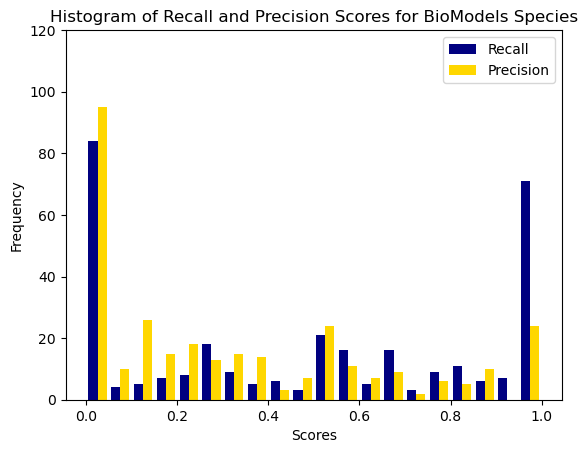

In [24]:
# BioModels species
df1 = biomd_species_accuracy.groupby('model')[['recall_formula', 'precision_formula']].mean()
ax = plt.gca()
ax.hist(x=[df1['recall_formula'], df1['precision_formula']], bins=20, color=['navy', 'gold'], label=['Recall', 'Precision'])
ax.set_ylim(0, 120)
ax.set_xlabel('Scores')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Recall and Precision Scores for BioModels Species')
ax.legend(loc='upper right')
plt.savefig(os.path.join(output_dir, 'biomd_spec_hist.png'), dpi=300, bbox_inches='tight', pad_inches=0.0)

In [36]:
# Only consider model id less than BIOMD0000001000.xml
biomd_species_accuracy_first1000 = biomd_species_accuracy[biomd_species_accuracy['model'] < 'BIOMD0000001000.xml']
print("\n\n<BioModels Species first 1000>")
print("Number of models assessed: %d" % biomd_species_accuracy_first1000['model'].nunique())
print("Average recall (per model): %.02f" % biomd_species_accuracy_first1000.groupby('model')['recall'].mean().mean())
print("Average precision (per model): %.02f" % biomd_species_accuracy_first1000.groupby('model')['precision'].mean().mean())
print("Average match score (per model): %.02f" % biomd_species_accuracy_first1000.groupby('model')['match_score'].mean().mean())
print("Average accuracy (per model): %.02f" % biomd_species_accuracy_first1000.groupby('model')['accuracy'].mean().mean())



<BioModels Species first 1000>
Number of models assessed: 306
Average recall (per model): 0.48
Average precision (per model): 0.31
Average match score (per model): 0.97
Average accuracy (per model): 0.48


### BioModels reaction statistics

In [135]:
output_csv = 'biomd_model_reaction_statistics.csv'
generate_model_reaction_statistics(biomd_model_dir, output_dir+output_csv)

We are at 0
We are at 100
We are at 200
We are at 300
We are at 400
We are at 500
We are at 600
We are at 700
We are at 800
We are at 900
We are at 1000


In [30]:
# Read in the output CSV file
biomd_model_reaction_statistics = pd.read_csv(output_dir+'biomd_model_reaction_statistics.csv')
biomd_model_reaction_statistics.head()

,model,annotated,num_reactions,num_annotated_reactions,processing_time
0,BIOMD0000000634.xml,False,112,0,NaN
1,BIOMD0000000152.xml,True,120,34,20.656115
2,BIOMD0000000146.xml,False,34,0,NaN
3,BIOMD0000000620.xml,False,20,0,NaN
4,BIOMD0000000608.xml,False,140,0,NaN


In [31]:
print("\n\n<BioModels Reactions>")
# Models with annotated reactions
annotated_reactions_df = biomd_model_reaction_statistics[biomd_model_reaction_statistics['annotated']]
spec_biomodels = np.unique(annotated_reactions_df['model'])
print("Number of Models with Annotated Reactions: %d" % len(spec_biomodels))

# Ave. number of reactions in models with annotated reactions
ave_num_reactions = annotated_reactions_df['num_reactions'].mean()
print("Ave. number of reactions: %.02f" % ave_num_reactions)

# Ave. number of annotated reactions in models with annotated reactions
ave_num_annoted_reactions = annotated_reactions_df['num_annotated_reactions'].mean()
print("Ave. number of annotated reactions: %.02f" % ave_num_annoted_reactions)

# Ave. processing time (per model)
ave_processing_time = annotated_reactions_df['processing_time'].mean()
print("Ave. processing time (per model): %.02f" % ave_processing_time)

# Ave. processing time (per element, per model)
ave_processing_time_per_element = ave_processing_time / ave_num_annoted_reactions
print("Ave. processing time (per element, per model): %.02f" % ave_processing_time_per_element)



<BioModels Reactions>
Number of Models with Annotated Reactions: 135
Ave. number of reactions: 103.90
Ave. number of annotated reactions: 46.93
Ave. processing time (per model): 30.53
Ave. processing time (per element, per model): 0.65


In [32]:
# Only consider the first 1000 models
biomd_model_reaction_statistics_first1000 = biomd_model_reaction_statistics.sort_values(by='model').head(1000)

print("\n\n<BioModels Reactions first 1000>")
# Models with annotated reactions
annotated_reactions_df = biomd_model_reaction_statistics_first1000[biomd_model_reaction_statistics_first1000['annotated']]
spec_biomodels = np.unique(annotated_reactions_df['model'])
print("Number of Models with Annotated Reactions: %d" % len(spec_biomodels))

# Ave. number of reactions in models with annotated reactions
ave_num_reactions = annotated_reactions_df['num_reactions'].mean()
print("Ave. number of reactions: %.02f" % ave_num_reactions)

# Ave. number of annotated reactions in models with annotated reactions
ave_num_annoted_reactions = annotated_reactions_df['num_annotated_reactions'].mean()
print("Ave. number of annotated reactions: %.02f" % ave_num_annoted_reactions)

# Ave. processing time (per model)
ave_processing_time = annotated_reactions_df['processing_time'].mean()
print("Ave. processing time (per model): %.02f" % ave_processing_time)

# Ave. processing time (per element, per model)
ave_processing_time_per_element = ave_processing_time / ave_num_annoted_reactions
print("Ave. processing time (per element, per model): %.02f" % ave_processing_time_per_element)





<BioModels Reactions first 1000>
Number of Models with Annotated Reactions: 131
Ave. number of reactions: 42.64
Ave. number of annotated reactions: 16.70
Ave. processing time (per model): 8.62
Ave. processing time (per element, per model): 0.52


In [122]:
output_csv = 'biomd_reaction_accuracy.csv'
generate_reaction_accuracy(biomd_model_dir, output_dir+output_csv)

We are at 0
We are at 100
We are at 200
We are at 300
We are at 400
We are at 500
We are at 600
We are at 700
We are at 800
We are at 900
We are at 1000


In [9]:
# Because the number of reaction candidates, the csv file is too large
# Save a smaller version with only the first 10 candidates
biomd_reaction_accuracy = pd.read_csv(output_dir+'biomd_reaction_accuracy.csv')
biomd_reaction_accuracy_small = biomd_reaction_accuracy.copy()
biomd_reaction_accuracy_small['predictions'] = biomd_reaction_accuracy_small['predictions'].apply(lambda x: x[:10])
biomd_reaction_accuracy_small.to_csv(output_dir+'biomd_reaction_accuracy_small.csv', index=False)


In [40]:
biomd_reaction_accuracy_small = pd.read_csv(output_dir+'biomd_reaction_accuracy_small.csv')
print("\n\n<BioModels Reactions>")
print("Number of models assessed: %d" % biomd_reaction_accuracy_small['model'].nunique())
print("Average recall (per model): %.02f" % biomd_reaction_accuracy_small.groupby('model')['recall'].mean().mean())
print("Average precision (per model): %.02f" % biomd_reaction_accuracy_small.groupby('model')['precision'].mean().mean())
print("Average match score (per model): %.02f" % biomd_reaction_accuracy_small.groupby('model')['match_score'].mean().mean())
print("Average accuracy (per model): %.02f" % biomd_reaction_accuracy_small.groupby('model')['accuracy'].mean().mean())




<BioModels Reactions>
Number of models assessed: 135
Average recall (per model): 0.34
Average precision (per model): 0.09
Average match score (per model): 0.61
Average accuracy (per model): 0.37


In [39]:
biomd_reaction_accuracy_small_first1000 = biomd_reaction_accuracy_small[biomd_reaction_accuracy_small['model'] < 'BIOMD0000001000.xml']
print("\n\n<BioModels Reactions first 1000>")
print("Number of models assessed: %d" % biomd_reaction_accuracy_small_first1000['model'].nunique())
print("Average recall (per model): %.02f" % biomd_reaction_accuracy_small_first1000.groupby('model')['recall'].mean().mean())
print("Average precision (per model): %.02f" % biomd_reaction_accuracy_small_first1000.groupby('model')['precision'].mean().mean())
print("Average match score (per model): %.02f" % biomd_reaction_accuracy_small_first1000.groupby('model')['match_score'].mean().mean())
print("Average accuracy (per model): %.02f" % biomd_reaction_accuracy_small_first1000.groupby('model')['accuracy'].mean().mean())




<BioModels Reactions first 1000>
Number of models assessed: 131
Average recall (per model): 0.34
Average precision (per model): 0.09
Average match score (per model): 0.61
Average accuracy (per model): 0.36


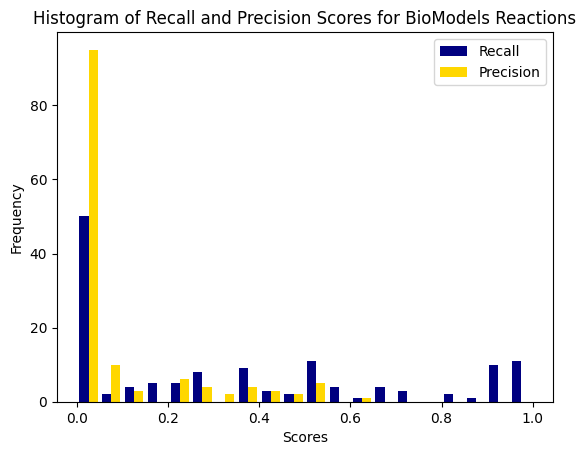

In [41]:
# BioModels reactions
df2 = biomd_reaction_accuracy_small.groupby('model')[['recall', 'precision']].mean()
ax = plt.gca()
ax.hist(x=[df2['recall'], df2['precision']], bins=20, color=['navy', 'gold'], label=['Recall', 'Precision'])
ax.set_xlabel('Scores')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Recall and Precision Scores for BioModels Reactions')
ax.legend(loc='upper right')
plt.savefig(os.path.join(output_dir, 'biomd_reac_hist.png'), dpi=300, bbox_inches='tight', pad_inches=0.0)

### Bigg models species statistics

In [138]:
output_csv = 'bigg_model_species_statistics.csv'
generate_model_species_statistics(bigg_model_dir, output_dir+output_csv)

We are at 0
We are at 100


In [43]:
print("\n\n<Bigg Models Species>")
# Models with annotated species
annotated_species_df = pd.read_csv(output_dir+'bigg_model_species_statistics.csv')
spec_biomodels = np.unique(annotated_species_df['model'])
print("Number of Models with Annotated Species: %d" % len(spec_biomodels))

# Ave. number of species in models with annotated species
ave_num_specs = annotated_species_df['num_species'].mean()
print("Ave. number of species: %.02f" % ave_num_specs)

# Ave. number of annotated species in models with annotated species
ave_num_annoted_specs = annotated_species_df['num_annotated_species'].mean()
print("Ave. number of annotated species: %.02f" % ave_num_annoted_specs)

# Ave. processing time (per model)
ave_processing_time = annotated_species_df['processing_time'].mean()
print("Ave. processing time (per model): %.02f" % ave_processing_time)

# Ave. processing time (per element, per model)
ave_processing_time_per_element = ave_processing_time / ave_num_annoted_specs
print("Ave. processing time (per element, per model): %.02f" % ave_processing_time_per_element)




<Bigg Models Species>
Number of Models with Annotated Species: 108
Ave. number of species: 1674.09
Ave. number of annotated species: 1233.64
Ave. processing time (per model): 323.13
Ave. processing time (per element, per model): 0.26


In [5]:
output_csv = 'bigg_species_accuracy_AMAS.csv'
generate_species_accuracy(bigg_model_dir, output_dir+output_csv)

We are at 0
We are at 1
We are at 2
We are at 3
We are at 4
We are at 5
We are at 6
We are at 7
We are at 8
We are at 9
We are at 10
We are at 11
We are at 12
We are at 13
We are at 14
We are at 15
We are at 16
We are at 17
We are at 18
We are at 19
We are at 20
We are at 21
We are at 22
We are at 23
We are at 24
We are at 25
We are at 26
We are at 27
We are at 28
We are at 29
We are at 30
We are at 31
We are at 32
We are at 33
We are at 34
We are at 35
We are at 36
We are at 37
We are at 38
We are at 39
We are at 40
We are at 41
We are at 42
We are at 43
We are at 44
We are at 45
We are at 46
We are at 47
We are at 48
We are at 49
We are at 50
We are at 51
We are at 52
We are at 53
We are at 54
We are at 55
We are at 56
We are at 57
We are at 58
We are at 59
We are at 60
We are at 61
We are at 62
We are at 63
We are at 64
We are at 65
We are at 66
We are at 67
We are at 68
We are at 69
We are at 70
We are at 71
We are at 72
We are at 73
We are at 74
We are at 75
We are at 76
We are at

In [139]:
output_csv = 'bigg_model_reaction_statistics.csv'
generate_model_reaction_statistics(bigg_model_dir, output_dir+output_csv)

We are at 0
We are at 100


In [25]:
bigg_species_accuracy = pd.read_csv(output_dir+'bigg_species_accuracy_AMAS.csv')
bigg_species_accuracy.head()

,model,species_id,species_name,name_length,predictions,num_candidates,num_formulas,match_score,recall_formula,precision_formula,recall_chebi,precision_chebi,accuracy,processing_time
0,iCHOv1.xml,M_3mob_c,3-Methyl-2-oxobutanoate,23,"[('CHEBI:11851', np.float64(1.0)), ('CHEBI:165...",3,1,1.000,1.0,1.0,0.333,0.667,1,184.829248
1,iCHOv1.xml,M_3mob_e,3-Methyl-2-oxobutanoate,23,"[('CHEBI:11851', np.float64(1.0)), ('CHEBI:165...",3,1,1.000,1.0,1.0,0.333,0.667,1,184.829248
2,iCHOv1.xml,M_10fthf_c,10-Formyltetrahydrofolate,25,"[('CHEBI:15637', np.float64(1.0))]",1,1,1.000,1.0,1.0,0.167,1.000,1,184.829248
3,iCHOv1.xml,M_3mob_m,3-Methyl-2-oxobutanoate,23,"[('CHEBI:11851', np.float64(1.0)), ('CHEBI:165...",3,1,1.000,1.0,1.0,0.333,0.667,1,184.829248
4,iCHOv1.xml,M_2kmb_c,2-keto-4-methylthiobutyrate,27,"[('CHEBI:89255', np.float64(0.958))]",1,1,0.958,0.0,0.0,0.000,0.000,0,184.829248


In [29]:
df = pd.read_csv(output_dir + 'bigg_species_accuracy_AMAS.csv')
# Get the first 10 unique models
unique_models = df['model'].unique()[:10]
bigg_species_accuracy = df[df['model'].isin(unique_models)].copy()  # Create a copy to avoid SettingWithCopyWarning

print("\n\n<Bigg Species>")
print("Number of models assessed: %d" % bigg_species_accuracy['model'].nunique())
print("Average recall (per model) using formula: %.02f" % bigg_species_accuracy.groupby('model')['recall_formula'].mean().mean())
print("Average precision (per model) using formula: %.02f" % bigg_species_accuracy.groupby('model')['precision_formula'].mean().mean())
print("Average recall (per model) using ChEBI ID: %.02f" % bigg_species_accuracy.groupby('model')['recall_chebi'].mean().mean())
print("Average precision (per model) using ChEBI ID: %.02f" % bigg_species_accuracy.groupby('model')['precision_chebi'].mean().mean())
print("Average match score (per model): %.02f" % bigg_species_accuracy.groupby('model')['match_score'].mean().mean())
print("Average accuracy (per model): %.02f" % bigg_species_accuracy.groupby('model')['accuracy'].mean().mean())
# Fixed processing time calculations
mean_processing_time = bigg_species_accuracy.groupby('model')['processing_time'].first().mean()
print("Ave. processing time (per model): %.02f" % mean_processing_time)
# Calculate per element processing time
num_elements = bigg_species_accuracy.groupby('model').size().mean()
mean_processing_time_per_element = mean_processing_time / num_elements
print("Ave. processing time (per element, per model): %.02f" % mean_processing_time_per_element)
# Average number of predictions per species
def safe_eval_with_eval(x):
    try:
        return eval(x) if isinstance(x, str) else []
    except Exception as e:
        print(f"Failed to parse: {x} with error: {e}")
        return []
bigg_species_accuracy['parsed_predictions'] = bigg_species_accuracy['predictions'].apply(safe_eval_with_eval)
bigg_species_accuracy['num_predictions'] = bigg_species_accuracy['parsed_predictions'].apply(len)
# Calculate the average number of predictions
average_predictions = bigg_species_accuracy['num_predictions'].mean()
print(f"Average number of predictions per row: {average_predictions}")



<Bigg Species>
Number of models assessed: 10
Average recall (per model) using formula: 0.85
Average precision (per model) using formula: 0.81
Average recall (per model) using ChEBI ID: 0.24
Average precision (per model) using ChEBI ID: 0.75
Average match score (per model): 0.98
Average accuracy (per model): 0.86
Ave. processing time (per model): 104.87
Ave. processing time (per element, per model): 0.09
Average number of predictions per row: 1.8037638865859724


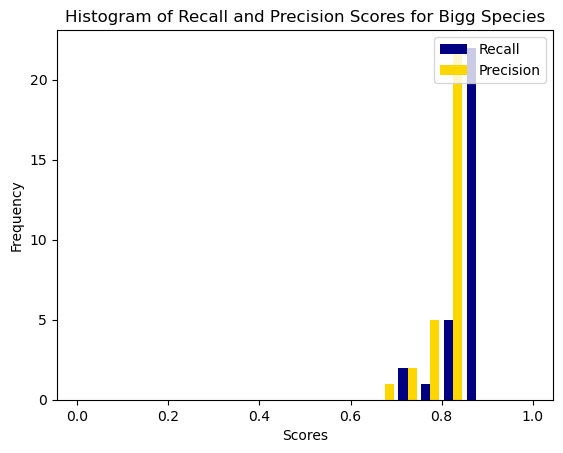

In [28]:
# Bigg species
df1 = bigg_species_accuracy.groupby('model')[['recall_formula', 'precision_formula']].mean()
ax = plt.gca()
ax.hist(x=[df1['recall_formula'], df1['precision_formula']], bins=20, color=['navy', 'gold'], label=['Recall', 'Precision'], range=(0, 1))
ax.set_xlabel('Scores')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Recall and Precision Scores for Bigg Species')
ax.legend(loc='upper right')
plt.savefig(os.path.join(output_dir, 'biomd_spec_hist.png'), dpi=300, bbox_inches='tight', pad_inches=0.0)

In [44]:
print("\n\n<Bigg Models Reactions>")
# Models with annotated reactions
annotated_reactions_df = pd.read_csv(output_dir+'bigg_model_reaction_statistics.csv')
spec_biomodels = np.unique(annotated_reactions_df['model'])
print("Number of Models with Annotated Reactions: %d" % len(spec_biomodels))

# Ave. number of reactions in models with annotated reactions
ave_num_reactions = annotated_reactions_df['num_reactions'].mean()
print("Ave. number of reactions: %.02f" % ave_num_reactions)

# Ave. number of annotated reactions in models with annotated reactions
ave_num_annoted_reactions = annotated_reactions_df['num_annotated_reactions'].mean()
print("Ave. number of annotated reactions: %.02f" % ave_num_annoted_reactions)

# Ave. processing time (per model)
ave_processing_time = annotated_reactions_df['processing_time'].mean()
print("Ave. processing time (per model): %.02f" % ave_processing_time)

# Ave. processing time (per element, per model)
ave_processing_time_per_element = ave_processing_time / ave_num_annoted_reactions
print("Ave. processing time (per element, per model): %.02f" % ave_processing_time_per_element)




<Bigg Models Reactions>
Number of Models with Annotated Reactions: 108
Ave. number of reactions: 2328.00
Ave. number of annotated reactions: 1119.92
Ave. processing time (per model): 727.05
Ave. processing time (per element, per model): 0.65


In [49]:
output_csv = 'bigg_reaction_accuracy.csv'
generate_reaction_accuracy(bigg_model_dir, output_dir+output_csv)

We are at 0
We are at 1
We are at 2
We are at 3
We are at 4
We are at 5
We are at 6
We are at 7
We are at 8
We are at 9
We are at 10
We are at 11
We are at 12
We are at 13
We are at 14
We are at 15
We are at 16
We are at 17
We are at 18
We are at 19
We are at 20
We are at 21
We are at 22
We are at 23
We are at 24
We are at 25
We are at 26
We are at 27
We are at 28
We are at 29
We are at 30
We are at 31
We are at 32
We are at 33
We are at 34
We are at 35
We are at 36
We are at 37
We are at 38
We are at 39
We are at 40
We are at 41
We are at 42
We are at 43
We are at 44
We are at 45
We are at 46
We are at 47
We are at 48
We are at 49
We are at 50
We are at 51
We are at 52
We are at 53
We are at 54
We are at 55
We are at 56
We are at 57
We are at 58
We are at 59
We are at 60
We are at 61
We are at 62
We are at 63
We are at 64
We are at 65
We are at 66
We are at 67
We are at 68
We are at 69
We are at 70
We are at 71
We are at 72
We are at 73
We are at 74
We are at 75
We are at 76
We are at

In [50]:
bigg_reaction_accuracy = pd.read_csv(output_dir+'bigg_reaction_accuracy.csv')
print("\n\n<Bigg Reactions>")
print("Number of models assessed: %d" % bigg_reaction_accuracy['model'].nunique())
print("Average recall (per model): %.02f" % bigg_reaction_accuracy.groupby('model')['recall'].mean().mean())
print("Average precision (per model): %.02f" % bigg_reaction_accuracy.groupby('model')['precision'].mean().mean())
print("Average match score (per model): %.02f" % bigg_reaction_accuracy.groupby('model')['match_score'].mean().mean())
print("Average accuracy (per model): %.02f" % bigg_reaction_accuracy.groupby('model')['accuracy'].mean().mean())



<Bigg Reactions>
Number of models assessed: 108
Average recall (per model): 0.56
Average precision (per model): 0.30
Average match score (per model): 0.83
Average accuracy (per model): 0.67


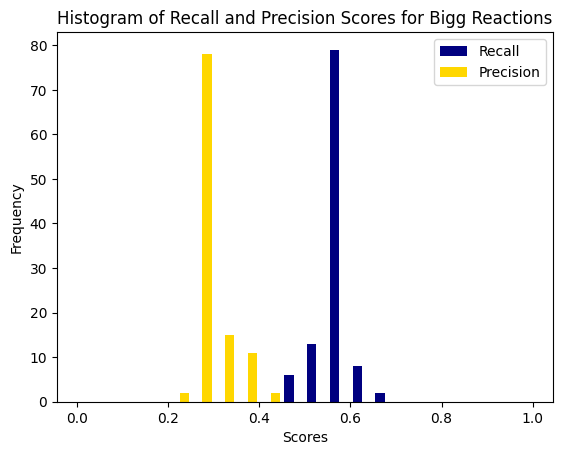

In [51]:
# Bigg reactions
df2 = bigg_reaction_accuracy.groupby('model')[['recall', 'precision']].mean()
ax = plt.gca()
ax.hist(x=[df2['recall'], df2['precision']], bins=20, color=['navy', 'gold'], label=['Recall', 'Precision'], range=(0, 1))
ax.set_xlabel('Scores')
ax.set_ylabel('Frequency')
ax.set_title('Histogram of Recall and Precision Scores for Bigg Reactions')
ax.legend(loc='upper right')
plt.savefig(os.path.join(output_dir, 'biomd_reac_hist.png'), dpi=300, bbox_inches='tight', pad_inches=0.0)